# Alfred the Mail Sorting Butler: A LangGraph Example

In this notebook, **we're going to build a complete email processing workflow using LangGraph**.

This notebook is part of the <a href="https://www.hf.co/learn/agents-course">Hugging Face Agents Course</a>, a free course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

## What You'll Learn

In this notebook, you'll learn how to:
1. Set up a LangGraph workflow
2. Define state and nodes for email processing
3. Create conditional branching in a graph
4. Connect an LLM for classification and content generation
5. Visualize the workflow graph
6. Execute the workflow with example data

In [1]:
# Install the required packages
%pip install -q langgraph langchain_openai langchain_huggingface

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setting Up Our Environment

First, let's import all the necessary libraries. LangGraph provides the graph structure, while LangChain offers convenient interfaces for working with LLMs.

In [2]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

# Set your OpenAI API key here
os.environ["OPENAI_API_KEY"] = ""  # Replace with your actual API key

# Initialize our LLM
model = ChatOpenAI(model="gpt-4o", openai_api_base="https://api.chatanywhere.tech/v1", temperature=0)

## Step 1: Define Our State

In LangGraph, **State** is the central concept. It represents all the information that flows through our workflow.

For Alfred's email processing system, we need to track:
- The email being processed
- Whether it's spam or not
- The draft response (for legitimate emails)
- Conversation history with the LLM

In [3]:
class EmailState(TypedDict):
    # 正在处理的电子邮件
    email: Dict[str, Any]   # 包含主题、发件人、正文等
    # 分析与决策
    is_spam: Optional[bool]
    spam_reason: Optional[str]
    email_category: Optional[str]
    email_draft: Optional[str]
    # 处理元数据
    messages: List[Dict[str, Any]]

## Step 2: Define Our Nodes

In [4]:
def read_email(state: EmailState):
    """
    读取邮件节点：打印正在处理的邮件信息
    """
    email = state["email"]
     # 打印处理中的邮件信息
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}   # 返回空字典，不修改状态


def classify_email(state: EmailState):
    """
    邮件分类节点：使用LLM判断邮件是否为垃圾邮件
    """
    email = state["email"]    # 获取邮件信息

    prompt = f"""
As Alfred the butler of Mr wayne and it's SECRET identity Batman, analyze this email and determine if it is spam or legitimate and should be brought to Mr wayne's attention.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

First, determine if this email is spam.
answer with SPAM or HAM if it's legitimate. Only return the answer
Answer :
    """
    # 创建消息并调用模型
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    # 解析模型响应，判断是否为垃圾邮件
    response_text = response.content.lower()
    print(response_text)
    is_spam = "spam" in response_text and "ham" not in response_text

    # 如果不是垃圾邮件，则将对话历史添加到消息中
    if not is_spam:
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response.content}
        ]
    else:
        # 如果是垃圾邮件，则不保存对话历史
        new_messages = state.get("messages", [])

    # 返回更新的状态
    return {
        "is_spam": is_spam,   # 垃圾邮件判断结果
        "messages": new_messages  # 更新后的消息历史
    }


def handle_spam(state: EmailState):
    """
    处理垃圾邮件节点：当邮件被标记为垃圾邮件时执行
    """
    # 打印处理垃圾邮件的信息
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}  # 返回空字典，不修改状态


def drafting_response(state: EmailState):
    """
    撰写回复节点：为合法邮件生成初步回复草稿
    """
    email = state["email"]   # 获取邮件信息

    # 构建提示词，让模型撰写回复
    prompt = f"""
As Alfred the butler, draft a polite preliminary response to this email.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Draft a brief, professional response that Mr. Wayne can review and personalize before sending.
    """

    # 创建消息并调用模型生成回复
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    # 将新的对话添加到消息历史中
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    # 返回更新的状态
    return {
        "email_draft": response.content,  # 生成的邮件回复草稿
        "messages": new_messages    # 更新后的消息历史
    }


def notify_mr_wayne(state: EmailState):
    """
    通知韦恩先生节点：向韦恩先生展示合法邮件及其草稿回复
    """
    email = state["email"]    # 获取邮件信息

    # 打印格式化的通知信息
    print("\n" + "=" * 50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-" * 50)
    print(state["email_draft"])    # 显示草稿回复
    print("=" * 50 + "\n")

    return {}    # 返回空字典，不修改状态


# 定义路由逻辑
def route_email(state: EmailState) -> str:
    """
    路由函数：根据邮件是否为垃圾邮件决定下一步走向
    """
    if state["is_spam"]:    # 如果是垃圾邮件
        return "spam"
    else:            # 如果是合法邮件
        return "legitimate"


# 创建图实例
email_graph = StateGraph(EmailState)

# 添加节点到图中
email_graph.add_node("read_email", read_email)   # 添加读取邮件节点，执行read_mail函数
email_graph.add_node("classify_email", classify_email)  # 添加分类邮件节点，执行classify_email函数
email_graph.add_node("handle_spam", handle_spam)  # 添加处理垃圾邮件节点，执行handle_spam函数
email_graph.add_node("drafting_response", drafting_response)   # 添加起草回复节点，执行drafting_response函数
email_graph.add_node("notify_mr_wayne", notify_mr_wayne)  # 添加通知韦恩先生节点，执行notify_mr_wayne函数


## Step 3: Define Our Routing Logic

In [5]:
# 添加边到图中，定义节点之间的连接关系
email_graph.add_edge(START, "read_email")  # 开始后转到"read_email"节点

email_graph.add_edge("read_email", "classify_email")  # 读取邮件后进行分类

# 添加条件边，根据路由函数的返回值决定流向
email_graph.add_conditional_edges(
    "classify_email", # 在分类邮件后，运行"route_email"函数
    route_email,      # 路由函数
    {
        "spam": "handle_spam",  # 如果返回"spam"，则转到"handle_spam"节点
        "legitimate": "drafting_response"  # 如果返回"legitimate"，则转到"drafting_response"节点
    }
)

# 添加最终边，定义流程结束路径
email_graph.add_edge("handle_spam", END)  #  # 处理垃圾邮件后总是结束
email_graph.add_edge("drafting_response", "notify_mr_wayne")   # 起草回复后通知韦恩先生
email_graph.add_edge("notify_mr_wayne", END)  # 通知韦恩先生后也可以结束


## Step 4: Create the StateGraph and Define Edges

In [6]:
# 编译图结构，将之前定义的所有节点和边整合成可执行的图
compiled_graph = email_graph.compile()

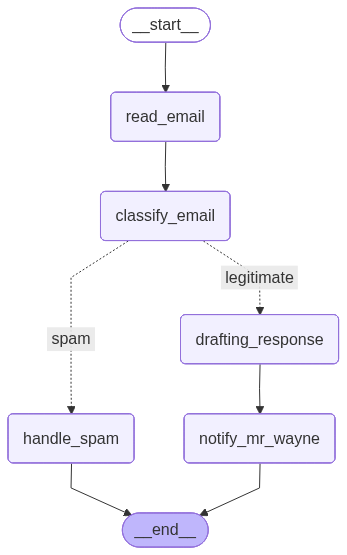

In [7]:
from IPython.display import Image, display

# 显示编译后的图结构的可视化图像
# 1. `compiled_graph.get_graph()` - 获取已编译的图对象
# 2. `.draw_mermaid_png()` - 使用Mermaid绘制图的PNG格式图像
# 3. `Image(...)` - 将PNG数据转换为IPython图像对象
# 4. `display(...)` - 在notebook单元格中显示图像
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [8]:
 # Example emails for testing
legitimate_email = {
    "sender": "Joker",
    "subject": "Found you Batman ! ",
    "body": "Mr. Wayne,I found your secret identity ! I know you're batman ! Ther's no denying it, I have proof of that and I'm coming to find you soon. I'll get my revenge. JOKER"
}

spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Response to Your Recent Correspondence

Dear Mr. Joker,

I hope this message finds you well. Your recent communication has been received and noted. I appreciate your efforts and understand your concerns. 

At this time, I would like to suggest a discussion to address any misunderstandings and explore potential resolutions.

Please feel free to contact me should you wish to arrange a mutually convenient time for a conversation.

Best regards,

[Your Name]  
On behalf of Bruce Wayne


Processing spam email...
Alfred is processing an email from Crypto bro with subject: The best investment of 2025
spam
Alfred has marked the email as spam.
The email has been moved to the spam folder.


## Step 5: Inspecting Our Mail Sorting Agent with Langfuse 📡

As Alfred fine-tunes the Main Sorting Agent, he's growing weary of debugging its runs. Agents, by nature, are unpredictable and difficult to inspect. But since he aims to build the ultimate Spam Detection Agent and deploy it in production, he needs robust traceability for future monitoring and analysis.

To do this, Alfred can use an observability tool such as [Langfuse](https://langfuse.com/) to trace and monitor the inner steps of the agent.

First, we need to install the necessary dependencies:

In [9]:
%pip install -q langfuse

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Next, we set the Langfuse API keys and host address as environment variables. You can get your Langfuse credentials by signing up for [Langfuse Cloud](https://cloud.langfuse.com) or [self-hosting Langfuse](https://langfuse.com/self-hosting).

In [10]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = ""
os.environ["LANGFUSE_SECRET_KEY"] = ""
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"  # 🇪🇺 EU region
# os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 US region

Now, we configure the [Langfuse `callback_handler`](https://langfuse.com/docs/integrations/langchain/tracing#add-langfuse-to-your-langchain-application).

In [12]:
%pip install langchain
from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


We then add `config={"callbacks": [langfuse_handler]}` to the invocation of the agents and run them again.

In [13]:
# Process legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke(
    input={
        "email": legitimate_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)

# Process spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke(
    input={
        "email": spam_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman ! 
ham

Sir, you've received an email from Joker.
Subject: Found you Batman ! 

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Inquiry

Dear Mr. Joker,

Thank you for reaching out. Your enthusiasm is noted, albeit unexpected. Mr. Wayne values his privacy and discretion regarding any personal matters. Kindly rest assured that any concerns will be addressed accordingly.

Best regards,

Alfred Pennyworth  
On behalf of Mr. Bruce Wayne


Processing spam email...
Alfred is processing an email from Crypto bro with subject: The best investment of 2025
spam
Alfred has marked the email as spam.
The email has been moved to the spam folder.


Alfred is now connected 🔌! The runs from LangGraph are being logged in Langfuse, giving him full visibility into the agent's behavior. With this setup, he's ready to revisit previous runs and refine his Mail Sorting Agent even further.

![Example trace in Langfuse](https://langfuse.com/images/cookbook/huggingface-agent-course/langgraph-trace-legit.png)

_[Public link to the trace with the legit email](https://cloud.langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/f5d6d72e-20af-4357-b232-af44c3728a7b?timestamp=2025-03-17T10%3A13%3A28.413Z&observation=6997ba69-043f-4f77-9445-700a033afba1)_

![Example trace in Langfuse](https://langfuse.com/images/cookbook/huggingface-agent-course/langgraph-trace-spam.png)

_[Public link to the trace with the spam email](https://langfuse.com/project/cloramnkj0002jz088vzn1ja4/traces/6e498053-fee4-41fd-b1ab-d534aca15f82?timestamp=2025-03-17T10%3A13%3A30.884Z&observation=84770fc8-4276-4720-914f-bf52738d44ba)_
